# Sentiment Analysis: Machine Learning Approach
This notebook explores a machine-learning-based sentiment analysis approach using the multinomial Naive Bayes (MultinomialNB) classifier.

## Import Libraries

In [8]:
import numpy as np
import pandas as pd
import spacy
import emoji
import re
import nltk # For downloading stopword lists and tokenization tools
from tqdm import tqdm
from nltk.sentiment.util import mark_negation
from sklearn import model_selection as ms # Model_selection module from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### Review Labeling

In [32]:
def review_labeling(data):
    df = pd.read_csv(data)
    
    # Apply the condition only to the second column (index 1)
    df['Label'] = df['Label'].apply(lambda x: 'positive' if x >= 4 else 'neutral' if 3 <= x < 4 else 'negative')
    
    return df

df_processed = review_labeling('Data/spotify_reviews_full.csv')

print(df_processed)

# Save labeled df as CSV file
df_processed.to_csv('Data/reviews_label_origin.csv', index=False)

                                                  Tokens     Label
0      Great music service, the audio is high quality...  positive
1      Please ignore previous negative rating. This a...  positive
2      This pop-up "Get the best Spotify experience o...  positive
3        Really buggy and terrible to use as of recently  negative
4      Dear Spotify why do I get songs that I didn't ...  negative
...                                                  ...       ...
61589  Even though it was communicated that lyrics fe...  negative
61590  Use to be sooo good back when I had it, and wh...  negative
61591  This app would be good if not for it taking ov...  negative
61592  The app is good hard to navigate and won't jus...  negative
61593  Its good but sometimes it doesnt load the musi...  positive

[61594 rows x 2 columns]


### Text Preprocessing

In [33]:
# Download lists of common English stopwords and punctuation characters.
nltk.download('stopwords')
nltk.download('punkt')

# Load spaCy model (English small)
nlp = spacy.load('en_core_web_sm')

# Function to map emojis to text. E.g., "Python is 👍" is transformed to "Python is :thumbs_up:"
def map_emojis(text):
    # Convert emojis to their text representations.
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Replace underscores with spaces in emoji descriptions to avoid them being omitted during tokenization.
    return text.replace('_', ' ')

# Preprocessing function
def preprocess_text(text):
    # Convert text to lowercase for normalization
    text = text.lower()

    # Convert emojis to text
    text = map_emojis(text)

    # Remove URLs and emails
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    # Tokenization and Lemmatization using spaCy
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_punct and not token.is_stop
    ]
    
    # Apply negation marking
    tokens = mark_negation(tokens)
    
    # Return the processed text as a space-separated string
    return ' '.join(tokens)

# Progress bars for pandas operations
tqdm.pandas(desc="Preprocessing Reviews")

# Apply preprocessing to the "Tokens" column of the DataFrame (df_processed)
df_processed["Tokens"] = df_processed["Tokens"].progress_apply(preprocess_text)

# Print head of DataFrame after preprocessing
print(df_processed.head())

# Save the preprocessed DataFrame to a CSV file
df_processed.to_csv('Data/reviews_preprocessed.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Preprocessing Reviews: 100%|██████████| 61594/61594 [06:33<00:00, 156.40it/s]


                                              Tokens     Label
0  great music service audio high quality app eas...  positive
1  ignore previous negative rating app super grea...  positive
2  pop good spotify experience android 12 annoyin...  positive
3                        buggy terrible use recently  negative
4            dear spotify song playlist shuffle play  negative


### Train/Test Splitting

In [35]:
# Extract the tokens as the feature data
df_text = df_processed["Tokens"]

# Extract the labels as the target data
df_target = df_processed["Label"]

# Split the dataset into training and testing subsets (80/20 Split)
train_data, test_data, train_target, test_target = ms.train_test_split(
    df_text, 
    df_target, 
    test_size=0.2, # 20% of the data will be used for testing
    random_state=993, # Seed for reproducibility of the split
    stratify=df_target # Ensures the class distribution is maintained
)

# Print the test target labels for verification/debugging
print(test_target)

30431    positive
53118    positive
30960    positive
34324    positive
59022    positive
           ...   
22075    positive
23612    positive
20156    negative
51588    negative
4962     negative
Name: Label, Length: 12319, dtype: object


### Count Vectorizer
Convert the text data into a bag-of-words representation using CountVectorizer, where each feature corresponds to a word in the vocabulary, and the value is the word's count in the document. This allows machine learning models to process textual data numerically, which captures  word usage patterns.

In [36]:
# Initialize the CountVectorizer
# This will convert text data into a bag-of-words representation
cv = CountVectorizer()

# Fit the vectorizer to the training data
train_features = cv.fit_transform(train_data)

# Print shape of resulting matrix
print(train_features.shape)

# Inspect first 3 rows of feature matrix
print(train_features[:3])

(49275, 20489)
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 45 stored elements and shape (3, 20489)>
  Coords	Values
  (0, 4427)	1
  (0, 14768)	1
  (0, 13765)	1
  (0, 6805)	1
  (0, 19452)	1
  (0, 984)	1
  (0, 16404)	1
  (0, 13350)	1
  (0, 10906)	1
  (0, 1693)	2
  (0, 2239)	1
  (0, 19477)	1
  (0, 8796)	1
  (0, 5156)	1
  (0, 7634)	1
  (0, 6981)	1
  (1, 19452)	1
  (1, 1693)	2
  (1, 11900)	1
  (1, 5846)	1
  (1, 19520)	1
  (1, 3743)	1
  (1, 7135)	1
  (1, 16906)	1
  (1, 15752)	1
  (1, 13178)	2
  (1, 8764)	1
  (1, 16814)	1
  (1, 10648)	1
  (1, 10367)	1
  (1, 19584)	1
  (1, 12541)	1
  (1, 7408)	1
  (1, 15981)	1
  (1, 14945)	1
  (1, 18251)	1
  (1, 15262)	1
  (1, 4560)	1
  (1, 12490)	1
  (2, 2239)	1
  (2, 5286)	1
  (2, 19567)	1
  (2, 11720)	1
  (2, 14942)	1
  (2, 2152)	1


### Binarization
Apply Binarizer to transform the word count features into binary values, where each feature is set to 1 if the count exceeds the threshold (default 0) and 0 otherwise. This can help reduce noise and simplify the feature space for certain models.

In [37]:
# Initialize the Binarizer
# This will threshold feature values, which converts them to binary (0 or 1)
transformer = Binarizer()

# Fit the Binarizer to the training features -> binary representation
train_bin = transformer.fit_transform(train_features)

# Print shape of resulting matrix
print(train_bin.shape)

# Print the first row of the binary matrix
print(train_bin[0])

(49275, 20489)
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 16 stored elements and shape (1, 20489)>
  Coords	Values
  (0, 4427)	1
  (0, 14768)	1
  (0, 13765)	1
  (0, 6805)	1
  (0, 19452)	1
  (0, 984)	1
  (0, 16404)	1
  (0, 13350)	1
  (0, 10906)	1
  (0, 1693)	1
  (0, 2239)	1
  (0, 19477)	1
  (0, 8796)	1
  (0, 5156)	1
  (0, 7634)	1
  (0, 6981)	1


## Classification Process

In [38]:
# Create a machine learning pipeline with three main components.
text_clf = Pipeline([
    # Convert text into bag-of-words representation 
    # min_df=10 -> ignore words in fewer than 10 documents, max_df=0.5 -> Ignore words that appear in more than 50% of documents
    ('vect', CountVectorizer(min_df=10, max_df=0.5)),  
    # Apply binarization
    ('binarizer', Binarizer()),
    # Use Multinomial NB for classification
    ('clf', MultinomialNB())
])

# Train the pipeline on the training data
text_clf.fit(train_data, train_target)

# Predict the labels for the test data using the trained pipeline
predicted = text_clf.predict(test_data)

# Create a DataFrame to compare the actual and predicted labels (optional)
# results = pd.DataFrame({
#    'Actual': test_target,
#    'Predicted': predicted
#})

### Confustion Matrix

Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.81      0.77      4954
     neutral       0.28      0.15      0.20      1377
    positive       0.83      0.84      0.83      5988

    accuracy                           0.75     12319
   macro avg       0.61      0.60      0.60     12319
weighted avg       0.73      0.75      0.74     12319



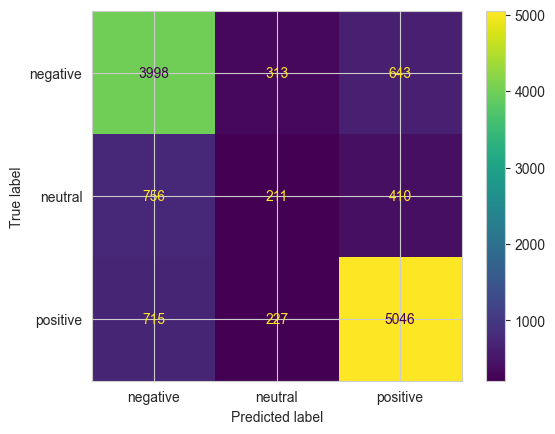

In [39]:
# Generate confusion matrix to evaluate classification performance
conf_matrix = confusion_matrix(test_target, predicted)
print("Confusion Matrix:")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=text_clf.classes_)
disp.plot()

# Generate classification report 
report = classification_report(test_target, predicted, target_names=text_clf.classes_)
print("Classification Report:")
print(report)